In [1]:
import os
import sys
import pandas as pd, geopandas as gp, matplotlib.pyplot as plt, numpy as np
import json
import fiona
import sys
import getpass
import requests
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import contextily as ctx

user = getpass.getuser()
sys.dont_write_bytecode = True

sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

from utils_io import *

# RHNA Site Selection Pre-Screening Dataset Processing

## Approach

Develop a parcel-level dataset containing factors required by HCD as well as optional factors such as whether the site is located within a high opportunity area, or a transportation priority area, any floor area ratio requirements of the site, etc. The dataset will be developed from a combination of publically available datasets as well as datasets developed by MTC/ABAG from local governments and counties throughout the Bay Area.

## Data Sources

**[Data Sources Inventory](https://mtcdrive.app.box.com/file/700718735166)**

## Pre-Processing Step
- This notebook is intented to support the overlay processing work to create the full housing element site selection dataset. Most of this work will not take place in one session so this pre-processing step is meant to be run before proceeding with steps below.  

In [3]:
#Box working directory path
data_dir = '../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

#Socrata housing site selection db 4x4
housing_site_db_id = 'ce94-ebgq'

#Pull housing site selection parcels from Socrata
parcels_geojson = pull_geojson_from_socrata(housing_site_db_id)

# Convert to geojson to geodataframe
parcel_columns = ['joinid',
                  'fipco',
                  'jurisdict',
                  'apn_frm',
                  'acres',
                  'tract_geoi',
                  'blkgp_geoi',
                  'reso_level',
                  'x_centroid',
                  'y_centroid',
                  'geometry']

parcels = gp.GeoDataFrame.from_features(parcels_geojson['features'],
                                        columns=parcel_columns,
                                        crs={'init': 'epsg:4326'})

#Convert centroid columns to float data type
parcels['x_centroid'] = parcels['x_centroid'].astype(float)
parcels['y_centroid'] = parcels['y_centroid'].astype(float)

parcels.head(5)

## Step 4: Process opportunity datasets

#### TCAC/HCD Resource Opportunity Areas 2020

- TCAC/HCD Resource Opportunity Area data was last updated in early 2020. 
- TCAC/HCD Resource Opportunity Area dataset contains data for the entire Bay Area by census tract and block group. 
    - For this work, the 'finalcat' or final category column will be added to the parcels dataset. To associate these data with parcels, we will use a two-step join operation. 
        - 1st join: join tract-level data to parcels using the tract geoid added to the framework dataset in earlier steps. This will be an 'inner' join as we only care about the matching records. 
        - 2nd join: join block group-level data to parcels using the block geoid added to the framework dataset in earlier steps. This will be an 'inner' join as we again only care about matching records. 
        - Blocks and Tracts were added to the framework dataset using a point in polygon method. 
    - Urban Areas provide data at the tract level while rural area data were provided at the block group level.

#### HUD Fair Market Rents

- Fair Market Rents (FMRs) data was last updated in 2019.
- Fair Market Rents (FMRs) are used to determine payment standard amounts for the Housing Choice Voucher program, to determine initial renewal rents for some expiring project-based Section 8 contracts, to determine initial rents for housing assistance payment (HAP) contracts in the Moderate Rehabilitation Single Room Occupancy program (Mod Rehab), rent ceilings for rental units in both the HOME Investment Partnerships program and the Emergency Solution Grants program, calculation of maximum award amounts for Continuum of Care recipients and the maximum amount of rent a recipient may pay for property leased with Continuum of Care funds, and calculation of flat rents in Public Housing units. 
- The U.S. Department of Housing and Urban Development (HUD) annually estimates FMRs for Office of Management and Budget (OMB) defined metropolitan areas, some HUD defined subdivisions of OMB metropolitan areas and each nonmetropolitan county. 42 USC 1437f requires FMRs be posted at least 30 days before they are effective and that they are effective at the start of the federal fiscal year (generally October 1).

### Process TCAC/HCD Resource Opportunity Areas 2020

In [4]:
data_dir

'../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

In [5]:
ls '../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/tabular'

ctcac_hcd_final_2020_public.xlsx


In [40]:
#Read in 2020 TCAC/HCD Resource Opportunity Areas

resource_areas = pd.read_excel(os.path.join(data_dir,'tabular/ctcac_hcd_final_2020_public.xlsx'),
                              dtype={'Census Tract':str,
                                     'Census Block Group':str})

In [41]:
#Inspect resource areas
resource_areas.head(5)

,Census Tract,Census Block Group,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,Final Category
0,06001400100,NaN,Alameda,6001.0,Bay Area Region,0.826,0.406,0.736,0.433,High Resource
1,06001400200,NaN,Alameda,6001.0,Bay Area Region,0.935,0.754,0.794,0.683,Highest Resource
2,06001400300,NaN,Alameda,6001.0,Bay Area Region,0.911,0.741,0.340,0.235,High Resource
3,06001400400,NaN,Alameda,6001.0,Bay Area Region,0.877,0.747,0.429,0.289,High Resource
4,06001400500,NaN,Alameda,6001.0,Bay Area Region,0.802,0.865,0.586,0.397,High Resource


In [42]:
#Return info about resource areas
resource_areas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10144 entries, 0 to 10143
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Census Tract                            10144 non-null  object 
 1   Census Block Group                      3093 non-null   object 
 2   County                                  10144 non-null  object 
 3   County ID                               10143 non-null  float64
 4   Region                                  10144 non-null  object 
 5   Economic Domain Score (by region)       9635 non-null   float64
 6   Environmental Domain Score (by region)  9635 non-null   float64
 7   Education Domain Score (by region)      9635 non-null   float64
 8   Composite Index Score                   8786 non-null   float64
 9   Final Category                          9635 non-null   object 
dtypes: float64(5), object(5)
memory usage: 792.6+ KB


In [43]:
resource_areas[resource_areas['Region'] == 'Bay Area Region'].shape

(1513, 10)

In [44]:
resource_areas['Final Category'].unique()

array(['High Resource', 'Highest Resource',
       'Moderate Resource (Rapidly Changing)', 'Moderate Resource',
       'Low Resource', 'High Segregation & Poverty', nan], dtype=object)

In [45]:
resource_areas['Region'].unique()

array(['Bay Area Region', 'Capital Region', 'Central Valley Region',
       'Inland Empire Region', 'Los Angeles Region',
       'Central Coast Region', 'Orange County Region', 'San Diego Region',
       'Rural Areas'], dtype=object)

In [46]:
#rename columns
resource_areas.rename(columns={'Census Tract':'tract_geoi',
                               'Census Block Group':'blkgp_geoi',
                               'Final Category':'reso_level'},inplace=True)

In [47]:
#subset resource areas at the tract level geography
ra_tracts = resource_areas[(resource_areas['tract_geoi'].notnull()) & 
                           (resource_areas['Region'] == 'Bay Area Region')]

In [48]:
ra_tracts.head(5)

,tract_geoi,blkgp_geoi,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,reso_level
0,06001400100,NaN,Alameda,6001.0,Bay Area Region,0.826,0.406,0.736,0.433,High Resource
1,06001400200,NaN,Alameda,6001.0,Bay Area Region,0.935,0.754,0.794,0.683,Highest Resource
2,06001400300,NaN,Alameda,6001.0,Bay Area Region,0.911,0.741,0.340,0.235,High Resource
3,06001400400,NaN,Alameda,6001.0,Bay Area Region,0.877,0.747,0.429,0.289,High Resource
4,06001400500,NaN,Alameda,6001.0,Bay Area Region,0.802,0.865,0.586,0.397,High Resource


In [49]:
ra_parcel_tracts = pd.merge(parcels[['joinid','tract_geoi']],
                            ra_tracts[['tract_geoi','reso_level']], 
                            on='tract_geoi',
                            how='inner')

In [50]:
ra_parcel_tracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1982228 entries, 0 to 1982227
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   joinid      object
 1   tract_geoi  object
 2   reso_level  object
dtypes: object(3)
memory usage: 60.5+ MB


In [51]:
parcels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2142255 entries, 0 to 2142254
Data columns (total 9 columns):
 #   Column      Dtype   
---  ------      -----   
 0   joinid      object  
 1   fipco       object  
 2   jurisdict   object  
 3   apn_frm     object  
 4   acres       object  
 5   tract_geoi  object  
 6   blkgp_geoi  object  
 7   reso_level  object  
 8   geometry    geometry
dtypes: geometry(1), object(8)
memory usage: 147.1+ MB


In [52]:
ra_parcel_tracts.head(10)

,joinid,tract_geoi,reso_level
0,SC257788,06085503218,Low Resource
1,SC257815,06085503218,Low Resource
2,SC257919,06085503218,Low Resource
3,SC257960,06085503218,Low Resource
4,SC258065,06085503218,Low Resource
5,SC260847,06085503218,Low Resource
6,SC260970,06085503218,Low Resource
7,SC262229,06085503218,Low Resource
8,SC262448,06085503218,Low Resource
9,SC263710,06085503218,Low Resource


In [53]:
#subset rural area block groups
ra_blkgp = resource_areas[(resource_areas['blkgp_geoi'].notnull()) & 
                           (resource_areas['Region'] == 'Rural Areas')]

In [54]:
ra_blkgp.head(5)

,tract_geoi,blkgp_geoi,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,reso_level
7051,06003010000,060030100001,Alpine,6003.0,Rural Areas,NaN,NaN,NaN,NaN,NaN
7052,06003010000,060030100002,Alpine,6003.0,Rural Areas,NaN,NaN,NaN,NaN,NaN
7053,06005000101,060050001011,Amador,6005.0,Rural Areas,0.192,0.885,0.115,-0.163,Moderate Resource
7054,06005000101,060050001012,Amador,6005.0,Rural Areas,0.115,0.885,0.115,-0.170,Low Resource
7055,06005000101,060050001013,Amador,6005.0,Rural Areas,0.077,0.885,0.115,-0.271,Low Resource


In [57]:
#Join to parcels
ra_parcel_blkgp = pd.merge(parcels[['joinid','blkgp_geoi']],
                          ra_blkgp[['blkgp_geoi','reso_level']],
                          on='blkgp_geoi',
                          how='inner')

In [58]:
ra_parcel_blkgp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158290 entries, 0 to 158289
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   joinid      158290 non-null  object
 1   blkgp_geoi  158290 non-null  object
 2   reso_level  156251 non-null  object
dtypes: object(3)
memory usage: 4.8+ MB


In [60]:
ra_parcel_blkgp.head(5)

,joinid,blkgp_geoi,reso_level
0,SC257886,060855135001,Low Resource
1,SC258294,060855135001,Low Resource
2,SC259092,060855135001,Low Resource
3,SC259228,060855135001,Low Resource
4,SC259712,060855135001,Low Resource


In [61]:
ra_parcels_tracts_blkgp = ra_parcel_tracts.append(ra_parcel_blkgp)

In [63]:
ra_parcels_tracts_blkgp.head(10)

,joinid,tract_geoi,reso_level,blkgp_geoi
0,SC257788,06085503218,Low Resource,NaN
1,SC257815,06085503218,Low Resource,NaN
2,SC257919,06085503218,Low Resource,NaN
3,SC257960,06085503218,Low Resource,NaN
4,SC258065,06085503218,Low Resource,NaN
5,SC260847,06085503218,Low Resource,NaN
6,SC260970,06085503218,Low Resource,NaN
7,SC262229,06085503218,Low Resource,NaN
8,SC262448,06085503218,Low Resource,NaN
9,SC263710,06085503218,Low Resource,NaN


In [64]:
ra_parcels_tracts_blkgp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140518 entries, 0 to 158289
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   joinid      object
 1   tract_geoi  object
 2   reso_level  object
 3   blkgp_geoi  object
dtypes: object(4)
memory usage: 81.7+ MB


In [65]:
ra_parcels_tracts_blkgp[ra_parcels_tracts_blkgp['blkgp_geoi'].notnull()]

,joinid,tract_geoi,reso_level,blkgp_geoi
0,SC257886,NaN,Low Resource,060855135001
1,SC258294,NaN,Low Resource,060855135001
2,SC259092,NaN,Low Resource,060855135001
3,SC259228,NaN,Low Resource,060855135001
4,SC259712,NaN,Low Resource,060855135001
...,...,...,...,...
158285,SN173115,NaN,Moderate Resource,060971538093
158286,SN173116,NaN,Moderate Resource,060971538093
158287,SN173117,NaN,Moderate Resource,060971538093
158288,SN173180,NaN,Moderate Resource,060971538093


In [66]:
#Upsert to socrata
upsert_df_socrata(ra_parcels_tracts_blkgp[['joinid','reso_level']],housing_site_db_id,chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to ce94-ebgq
took 9.0543 minutes


In [ ]:
# #Test process on subset of parcels
# resource_areas_nad83_sf = resource_areas_nad83[resource_areas_nad83['county'] == 'San Francisco']

# resource_areas_nad83_sf.head(5)

# parcels_resource_area_overlay_sf = gp.overlay(parcels_nad83_gdf,
#                                               resource_areas_nad83_sf[['finalcat','geometry']],
#                                               how='intersection')

# #Calculate overlay area
# parcels_resource_area_overlay_sf['overlay_area'] = parcels_resource_area_overlay_sf['geometry'].area

# #Calculate percentate overlay
# parcels_resource_area_overlay_sf['pct_overlay'] = (parcels_resource_area_overlay_sf['overlay_area'] /
#                                                   parcels_resource_area_overlay_sf['parcel_area'])
# #Get info 
# #(149828 rows)
# parcels_resource_area_overlay_sf.info()

# parcels_resource_area_overlay_sf[parcels_resource_area_overlay_sf['pct_overlay'] < 1]

# #Select parcels with the largest area within resource areas
# parcels_resource_area_overlay_largest_sf = (parcels_resource_area_overlay_sf
#                                             .iloc[parcels_resource_area_overlay_sf
#                                                   .groupby(['county_apn_id'])['pct_overlay']
#                                                   .idxmax()])

# #Check for duplicates
# #(0,11)
# parcels_resource_area_overlay_largest_sf[parcels_resource_area_overlay_largest_sf.duplicated(subset=['county_apn_id'])].shape

# #Get info again
# #(149657 rows)
# #Loss of rows 
# parcels_resource_area_overlay_largest_sf.info()

### Process HUD Fair Market Rents dataset

In [71]:
data_dir

'../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

In [72]:
!ls '../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

Intermediate Data
Potential_data_sources.xlsx
site_selection_prescreening_database.gdb
tabular


In [73]:
fiona.listlayers(os.path.join(data_dir,'site_selection_prescreening_database.gdb'))

['COCs_ACS2014_2018',
 'priority_development_areas_current',
 'US_Treasury_Opportunity_Zones_Bay_Area',
 'oehha_calenviroscreen3_bay_area',
 'u_richmond_mapping_inequality_redlining_07_2020',
 'hud_fair_market_rents_bay_area_7_28_20',
 'ca_healthy_places_index_bay_area_04_04_2018',
 'ctcac_hcd_resource_opportunity_areas_2020']

In [74]:
fmr = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                   driver='FileGDB',
                   layer='hud_fair_market_rents_bay_area_7_28_20')

In [75]:
fmr.head(10)

,FMR_0BDR,FMR_1BDR,FMR_2BDR,FMR_3BDR,FMR_4BDR,FMR_AREANAME,FMR_CODE,FMR_4PLUSBDR,Shape__Area,Shape__Length,Shape_Length,Shape_Area,geometry
0,1095.0,1289.0,1705.0,2465.0,2685.0,"Napa, CA MSA",METRO34900M34900,2685.0,3.340480e+09,349734.279550,2.788192,0.210944,"MULTIPOLYGON (((-122.35430 38.83715, -122.3499..."
1,983.0,1184.0,1443.0,2086.0,2531.0,"Vallejo-Fairfield, CA MSA",METRO46700M46700,2531.0,3.744063e+09,337353.781359,2.756668,0.237205,"MULTIPOLYGON (((-121.88139 38.53820, -121.8798..."
2,1397.0,1693.0,2109.0,2902.0,3558.0,"Oakland-Fremont, CA HUD Metro FMR Area",METRO41860MM5775,3558.0,6.241888e+09,621020.566568,5.063336,0.398083,"MULTIPOLYGON (((-121.58225 38.09489, -121.5812..."
3,1822.0,2255.0,2809.0,3663.0,3912.0,"San Francisco, CA HUD Metro FMR Area",METRO41860MM7360,3912.0,4.275324e+09,955407.207799,7.646650,0.272706,"MULTIPOLYGON (((-122.90949 38.31439, -122.9081..."
4,1865.0,2212.0,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458,"MULTIPOLYGON (((-121.86339 37.48462, -121.8007..."
5,1254.0,1447.0,1887.0,2728.0,3298.0,"Santa Rosa, CA MSA",METRO42220M42220,3298.0,6.739300e+09,497301.082655,4.051204,0.425442,"MULTIPOLYGON (((-123.01878 38.85237, -123.0069..."


In [76]:
fmr.columns = map(str.lower, fmr.columns)

In [77]:
fmr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   fmr_0bdr       6 non-null      float64 
 1   fmr_1bdr       6 non-null      float64 
 2   fmr_2bdr       6 non-null      float64 
 3   fmr_3bdr       6 non-null      float64 
 4   fmr_4bdr       6 non-null      float64 
 5   fmr_areaname   6 non-null      object  
 6   fmr_code       6 non-null      object  
 7   fmr_4plusbdr   6 non-null      float64 
 8   shape__area    6 non-null      float64 
 9   shape__length  6 non-null      float64 
 10  shape_length   6 non-null      float64 
 11  shape_area     6 non-null      float64 
 12  geometry       6 non-null      geometry
dtypes: float64(10), geometry(1), object(2)
memory usage: 752.0+ bytes


In [78]:
fmr.rename(columns={'fmr_4plusbdr':'fmr_4plbdr'},inplace=True)

In [79]:
fmr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   fmr_0bdr       6 non-null      float64 
 1   fmr_1bdr       6 non-null      float64 
 2   fmr_2bdr       6 non-null      float64 
 3   fmr_3bdr       6 non-null      float64 
 4   fmr_4bdr       6 non-null      float64 
 5   fmr_areaname   6 non-null      object  
 6   fmr_code       6 non-null      object  
 7   fmr_4plbdr     6 non-null      float64 
 8   shape__area    6 non-null      float64 
 9   shape__length  6 non-null      float64 
 10  shape_length   6 non-null      float64 
 11  shape_area     6 non-null      float64 
 12  geometry       6 non-null      geometry
dtypes: float64(10), geometry(1), object(2)
memory usage: 752.0+ bytes


In [82]:
fmr.crs

{'init': 'epsg:4326'}

In [96]:
parcels_centroid = gp.GeoDataFrame(parcels,
                                  geometry=gp.points_from_xy(parcels.x_centroid,parcels.y_centroid),
                                   crs={'init': 'epsg:4326'})

In [98]:
fmr_parcels_centroid = gp.sjoin(parcels_centroid,
                               fmr,
                               how='left',
                               op='intersects')

In [99]:
fmr_parcels_centroid.head(5)

,joinid,fipco,jurisdict,apn_frm,acres,tract_geoi,blkgp_geoi,reso_level,x_centroid,y_centroid,...,fmr_2bdr,fmr_3bdr,fmr_4bdr,fmr_areaname,fmr_code,fmr_4plbdr,shape__area,shape__length,shape_length,shape_area
0,SC257788,CA085,San Jose,None,0.118218005006097,06085503218,060855032182,None,-121.825062,37.278626,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458
1,SC257789,CA085,San Jose,None,0.148489035363832,06085512005,060855120051,None,-121.873356,37.264377,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458
2,SC257790,CA085,San Jose,None,0.125657625517105,06085502702,060855027024,None,-121.940662,37.255301,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458
3,SC257791,CA085,Los Gatos,None,0.294159103918568,06085507205,060855072054,None,-121.989760,37.253136,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458
4,SC257792,CA085,San Jose,None,1.06964856345635,06085500100,060855001001,None,-121.894749,37.362045,...,2712.0,3658.0,4198.0,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",METRO41940M41940,4198.0,5.314492e+09,470583.392021,3.858972,0.341458


In [100]:
fmr_parcels_centroid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2142255 entries, 0 to 2142254
Data columns (total 24 columns):
 #   Column         Dtype   
---  ------         -----   
 0   joinid         object  
 1   fipco          object  
 2   jurisdict      object  
 3   apn_frm        object  
 4   acres          object  
 5   tract_geoi     object  
 6   blkgp_geoi     object  
 7   reso_level     object  
 8   x_centroid     float64 
 9   y_centroid     float64 
 10  geometry       geometry
 11  index_right    float64 
 12  fmr_0bdr       float64 
 13  fmr_1bdr       float64 
 14  fmr_2bdr       float64 
 15  fmr_3bdr       float64 
 16  fmr_4bdr       float64 
 17  fmr_areaname   object  
 18  fmr_code       object  
 19  fmr_4plbdr     float64 
 20  shape__area    float64 
 21  shape__length  float64 
 22  shape_length   float64 
 23  shape_area     float64 
dtypes: float64(13), geometry(1), object(10)
memory usage: 408.6+ MB


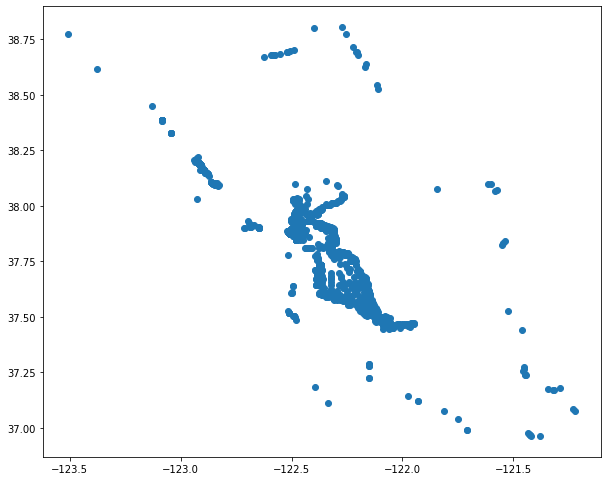

In [104]:
fmr_parcels_centroid[fmr_parcels_centroid['fmr_code'].isnull()].plot(figsize=(10,10));

In [105]:
#Subset not null values 
fmr_parcels_centroid_sub = fmr_parcels_centroid[fmr_parcels_centroid['fmr_code'].notnull()]

In [106]:
fmr_parcels_centroid_sub.shape

(2139678, 24)

In [107]:
fmr_parcels_centroid_sub.columns

Index(['joinid', 'fipco', 'jurisdict', 'apn_frm', 'acres', 'tract_geoi',
       'blkgp_geoi', 'reso_level', 'x_centroid', 'y_centroid', 'geometry',
       'index_right', 'fmr_0bdr', 'fmr_1bdr', 'fmr_2bdr', 'fmr_3bdr',
       'fmr_4bdr', 'fmr_areaname', 'fmr_code', 'fmr_4plbdr', 'shape__area',
       'shape__length', 'shape_length', 'shape_area'],
      dtype='object')

In [108]:
#upsert to socrata
sub_columns = ['joinid','fmr_0bdr', 'fmr_1bdr', 'fmr_2bdr', 'fmr_3bdr','fmr_4bdr','fmr_4plbdr']
upsert_df_socrata(fmr_parcels_centroid_sub[sub_columns],housing_site_db_id,chunksize=50000)

upserting data to Socrata in 43 chunks of 50000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
upserted chunk 22
upserted chunk 23
upserted chunk 24
upserted chunk 25
upserted chunk 26
upserted chunk 27
upserted chunk 28
upserted chunk 29
upserted chunk 30
upserted chunk 31
upserted chunk 32
upserted chunk 33
upserted chunk 34
upserted chunk 35
upserted chunk 36
upserted chunk 37
upserted chunk 38
upserted chunk 39
upserted chunk 40
upserted chunk 41
upserted chunk 42
data upserted to ce94-ebgq
took 11.1532 minutes


### Read in accessibility datasets

#### MTC/ABAG Transit Rich Areas

A Transit-Rich Area is defined as areas 1/2 mile of:
- An existing, under construction, or fully funded rail station or ferry terminal
- A rail station or ferry terminal included in the PBA 2050 Final Blueprint
- A bus stop with headways of 15 minutes or less during the AM (6:00 - 10:00 AM) and PM (3:00 - 7:00 PM) peak periods in January 2020

In [4]:
#Pull housing site selection parcels from Socrata
parcels_geojson = pull_geojson_from_socrata(housing_site_db_id)

pulling 2142255 rows as geojson


In [5]:
# Convert to geojson to geodataframe
parcel_columns = ['joinid',
                  'fipco',
                  'jurisdict',
                  'apn_frm',
                  'acres',
                  'tract_geoi',
                  'blkgp_geoi',
                  'reso_level',
                  'x_centroid',
                  'y_centroid',
                  'geometry']
parcels = gp.GeoDataFrame.from_features(parcels_geojson['features'],
                                        columns=parcel_columns,
                                        crs={'init': 'epsg:4326'})

In [ ]:
#MTC/ABAG Transit Rich Areas (2020)


In [ ]:
# # Spatial Overlay Method to only select parcels with a majority of area within Major Transit Stops buffer area. 
# # Attempted both spatial join and overlay methods which resulted in the same number of parcels flagged. 
# # Spatial join method performed a join, then grouped parcel by apn. This process disregarded percentage area overlap,
# # but was liberal in the sense that any parcel that intersected a stop buffer was counted. Spatial overlay method
# # was similarly liberal. Parcels within multiple buffer overlays were filtered to only include parcels maximally within
# # a set of stop buffers. The resulting dataset also included parcels that only intersected a single buffer overlay. 
# # These parcels were also included but could be filtered out using a percentage overlay threshold (eg parcel intersects
# # stop buffer 50% or more)
# #Area was calculated for parcels prior to this step. In following steps, area of intersect geom will be calculated, as well
# # as a percentage overlay to choose parcels with maximal overlay in cases where there are multiple stop buffers 
# # intersecting with parcels. 
# parcels_major_st_overlay = gp.overlay(parcels_nad83_gdf,stops_nad83_gdf,how='intersection')

# #Get info on gdf after overlay
# parcels_major_st_overlay.info()

# #Calculate area column. 
# parcels_major_st_overlay['overlay_area'] = parcels_major_st_overlay['geometry'].area

# #Calculate percentage overlay area
# parcels_major_st_overlay['pct_overlay'] = parcels_major_st_overlay['overlay_area'] / parcels_major_st_overlay['parcel_area']

# #Inspect results
# parcels_major_st_overlay.tail(10)

# #Get info on parcel, stops overlay 
# parcels_major_st_overlay.info()

# #Select parcels with largest area as a subset. As a result of overlaying parcels w/ multiple transit stop buffers,
# #there will be duplicated apns. We are only interested in parcels that intersecting with stop buffers generally, not in the 
# #particular individual relationship between a parcel and a given stops, stop buffer. 
# #So here we are grouping by apn, and selecting parcels that have the largest area overlap with stop buffers to create
# #a subset.
# #parcels_major_st_overlay.groupby(['county_apn_id'],group_keys=False)['area'].nlargest(1)
# parcels_major_st_overlay_largest = parcels_major_st_overlay.iloc[parcels_major_st_overlay.groupby(['county_apn_id'])['pct_overlay'].idxmax()]

# #Get info on parcels after filtering for largest parcel - stops buffer overlay area parcels
# parcels_major_st_overlay_largest.info()

# #Review parcels with less than 50% overlap. Because some parcels only intersect with one stop buffer, the 
# #percent overlay may be negligible. May want to set a percent overlay threshold for these cases or just 
# #go with a more libral approach and keep any parcels that intersect, even narrowly, with stop buffers. 
# parcels_major_st_overlay_largest[parcels_major_st_overlay_largest['pct_overlay'] < .50].head(10)

In [ ]:
#Spatial join to parcels using inner method - example of using this method vs. overlay method
# - Any parcel intersecting with buffer should be flagged
# - Only retain intersecting parcels; this dataset will be joined back to all parcels as final step later on
# - Intent is to ensure we don't have to keep tract of so many columns, reduces file sizes, and reduces the burdon
#   of worry about loss of base data as we will always have the 'master' copy

In [ ]:
#Check that projections are the same
print(parcels_nad83.crs)
print(stops_nad83_gdf.crs)

In [ ]:
#Spatially join the two gdfs
parcels_major_st = gp.sjoin(parcels_nad83,stops_nad83_gdf,how='inner',op='intersects')

In [ ]:
#Inspect spatial join output
parcels_major_st.head(10)

In [ ]:
#Check for duplicate rows after spatial join
parcels_major_st_dup = parcels_major_st[parcels_major_st.duplicated(subset=['joinid'])]

parcels_major_st_dup.shape

In [ ]:
#drop duplicated records created during intersect process 
parcels_major_st.drop_duplicates(subset=['joinid'],
                                    inplace=True)

In [ ]:
parcels_major_st.shape

In [ ]:
#Rename column
parcels_major_st.rename(columns={'major_stop':'tpa'},inplace=True)

In [ ]:
#Graph major stop parcels by county
parcels_major_ct = parcels_major_st.groupby(['fipco']).agg('size')

#plot
parcels_major_ct.plot(kind='bar',figsize=(10,10))

#title and labels
plt.title('Count of Parcels Near Major Transit Stops')
plt.xlabel('County')
plt.ylabel('Count')

plt.xticks( 
    [0,1,2,3,4,5,6,7,8], # positions
    ['Alameda','Contra Costa','Marin','Napa','San Francisco','San Mateo','Santa Clara','Solano','Sonoma'], # labels
    rotation = 0 # default is 90
)

# convert to non-scientific notation 
plt.ticklabel_format(axis = 'y', style='plain');

In [ ]:
#subset SF to view
parcels_major_st_sf = parcels_major_st[(parcels_major_st['tpa'] == 1) & 
                                               (parcels_major_st['jurisdict'] == 'San Francisco')]

In [ ]:
parcels_major_st_sf.plot(figsize=(10,10));

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

stops_nad83_gdf.plot(color='red',ax=ax)

parcels_major_st_sf.plot(color='blue',ax=ax)

# Crop map to sf bounds
minx, miny, maxx, maxy = parcels_major_st_sf.geometry.total_bounds

ax.set_xlim(minx,maxx)
ax.set_ylim(miny,maxy)

#Display map
plt.tight_layout()
plt.show()

In [ ]:
parcels.info()

In [ ]:
#Join back to parcels
parcels_major_st_full_set = pd.DataFrame.merge(parcels,parcels_major_st[['joinid','tpa']],
                                               left_on='joinid',
                                               right_on='joinid',
                                               how='left')

In [ ]:
parcels_major_st_full_set.head(10)

In [ ]:
#Fill tpa flag column NaN values
parcels_major_st_full_set['tpa'].fillna(0,inplace=True)

In [ ]:
parcels_major_st_full_set.groupby('tpa')['tpa'].count()

In [ ]:
#Upsert to socrata
upsert_df_socrata(parcels_major_st_full_set[['joinid','tpa']],housing_site_db_id)

### Read in Health Datasets

In [ ]:
#Read in California Healthy Places Index data
healthy_pi = gp.read_file(os.path.join(data_dir,'site_selection_prescreening_database.gdb'),
                          driver='FileGDB',
                          layer='ca_healthy_places_index_bay_area_04_04_2018')

healthy_pi.head(5)

In [ ]:
#Subset dataset
healthy_pi = healthy_pi[['STATE','COUNTY','TRACT','NAME','ct10','hpi2score','geometry']]


In [ ]:
#Get info
healthy_pi.info()

In [ ]:
healthy_pi.head(5)

### Read Regional Growth Areas

In [ ]:
#MTC/ABAG Priority Development Areas
pda_url = 'https://opendata.arcgis.com/datasets/36dd7a36576f42d4a3d6b0708e3982f4_0.geojson'
pda_gdf = gp.read_file(pda_url)
pda_gdf.head(5)